# Authors
1. Mateusz Nowicki
2. Jędrzej Miczke 156068

### Imports

In [166]:

import numpy as np
import math

import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from numpy.lib.stride_tricks import as_strided

### Data reading 

In [167]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels











### Dataframes creation

In [168]:
def read_and_concatenate_files(path_out):
    """
    Reads files in chunks of 6, concatenates the data, and creates DataFrames for each chunk.
    
    Parameters:
        files (list of str): List of file paths to load the data from.
        dx (float): Spacing between columns (default is 5.1065).
        dt (float): Time step for the frequency (default is 0.0016 seconds).
        
    Returns:
        List of pandas DataFrames: List of DataFrames for each chunk of 6 files.
    """
    dx=5.106500953873407
    dt=0.0016
    dataframes = []
    files = glob.glob(path_out+"*")
    files.sort()
    
    # Loop over the files in chunks of 6
    for i in range(0, len(files), 6):
        data_chunk = []
        
        # Process the current chunk of 6 files
        for file in files[i:i+6]:
            data_chunk.append(np.load(file))
        
        # Concatenate the data
        data_chunk = np.concatenate(data_chunk)
        
        # Retrieve start time for each chunk (using the first file in the chunk)
        time_start = datetime.datetime.strptime('2024-05-07 ' + files[i].split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
        
        # Create pandas date range (assumes each chunk has the same length)
        index = pd.date_range(start=time_start, periods=len(data_chunk), freq=f'{dt}s')
        
        # Create columns based on dx
        columns = np.arange(len(data_chunk[0])) * dx
        
        # Create DataFrame
        df = pd.DataFrame(data=data_chunk, index=index, columns=columns)
        
        # Store the DataFrame in the list
        dataframes.append(df)
    
    return dataframes


### Basic preprocessing

In [169]:
def basic_preprocessing(df, minmax=False,ret_dataframe=False):
    """
    Preprocesses a DataFrame by centering, taking absolute values,
    clipping outliers, and optionally applying min-max scaling.

    Parameters:
        df (pd.DataFrame): Input DataFrame to preprocess.
        minmax (bool): If True, applies min-max scaling to the data.

    Returns:
        pd.DataFrame: A new DataFrame with altered data, preserving the original index and columns.
    """
    # Make a copy of the input DataFrame to avoid modifying it
    new_df = df.copy()
    
    # Center the data by subtracting the mean
    new_df -= new_df.mean()
    
    # Take the absolute value
    new_df = np.abs(new_df)
    
    # Clip outliers at the 3rd and 99th percentiles
    low, high = np.percentile(new_df.values, [3, 99])  # Use .values to apply percentiles to the entire data
    
    new_df = np.clip(new_df, low, high)
    
    # Apply min-max scaling if specified
    if minmax:
        new_df = (new_df - low) / (high - low)
        new_df[new_df < 0] = 0  # Ensure lower values are clipped correctly

    # Return as DataFrame to preserve structure
    if ret_dataframe:
        return pd.DataFrame(new_df, index=df.index, columns=df.columns)
    else:
        numpy_array = new_df.to_numpy()
        return numpy_array

### Casting to grayscale image format 

In [170]:
'''binarization of data, setting a number of bins for data'''
# def convert_grayscale_data(df,scaling_parameter,ret_dataframe=True):
#     data = df.to_numpy()
#     data = np.floor(data *scaling_parameter)
#     data = data.astype(np.uint8)
#     if ret_dataframe:
#         return pd.DataFrame(data, index=df.index, columns=df.columns)
#     else:
#         return data

'binarization of data, setting a number of bins for data'

### Denoising

Unfortunately the data is inherently noisy which makes it difficult to process without some kind of denoising. We considered several kinds of denoising strategies 

1. First of all we observed the time fragments where there in our opinion no moving vehicle was visible, we took the mean of the values of the pixels for such scenario, and subtracted it from our images which we were processing. We subtracted the mean from the values below some threshold, not to shift the values of the whole pixels, but just to get rid of the noise,  acting in similar to the low pass filter. We spotted that first 3 files 090017-090037 seem to contain only noise.

2. The second approach was similar however we took the mean separately for each column, with assumption that maybe the noise is somehow  specific to each detector 

3. Last approach we tried to convert the image to the frequency domain and see , the frequencies distribution, and get rid of the high frequencies corresponding most likely to the noise.

In [171]:
'''binarization of data, setting a number of bins for data'''
def rescale_data(df,scaling_parameter,ret_dataframe=True):
    data = df.to_numpy()
    data = np.floor(data *scaling_parameter)
    data = data.astype(np.uint8)
    if ret_dataframe:
        return pd.DataFrame(data, index=df.index, columns=df.columns)
    else:
        return data






'''just subtracting the mean of the noise observed on the data, where only noise were'''
def mean_denoising(noise,image,constant, ret_dataframe = True,threshold=None):
    img = image.to_numpy()
    if not threshold:
        threshold = np.median(img)
    mean_of_noise = np.mean(noise)
    img = np.where(img>threshold, img, np.maximum(img-(constant*mean_of_noise),0))
    print(np.all(img>=0))
    if ret_dataframe:
        return pd.DataFrame(img, index=image.index, columns=image.columns)
    else:
        return img

    
'''subtracting the mean of the noise but for each column- each measuring point separatley '''
def column_denoising(noise,image,constant,ret_dataframe = True, threshold=None):
    img = image.to_numpy()
    if not threshold:
        threshold = np.median(img)
    mean_of_noise_columns = np.mean(noise,axis=0)
    subtracted =  img - (constant*mean_of_noise_columns)
    subtracted = np.maximum(0,subtracted)
    to_return= np.where(img>threshold,img,subtracted)
    if ret_dataframe:
        return pd.DataFrame(to_return, index=image.index, columns=image.columns)
    else:
        to_return

# def normalizing_columns(image):
#     pass

'''basicaly just subtracting noise '''
def subtract_noise(noise,image ,ret_dataframe = True):
    img = image.to_numpy()
    repeat_factor = img.shape[0] // noise.shape[0]
    reshaped_noise = np.repeat(noise, repeat_factor, axis=0)
    
    # Subtract noise from image
    result = img - reshaped_noise
    result = np.where(result>0,result,0)
    
    # Return as DataFrame if needed
    if ret_dataframe:
        return pd.DataFrame(result, index=image.index, columns=image.columns)
    else:
        return result
    
'''performed due to the fact that some of the columns as whole seemed to be more saturated even though no vehicle passed there '''
def normalizing_columns(image, target_sum=1, ret_dataframe=True):
    """
    Normalize each column of the given image so that the sum of each column equals the target_sum.

    Parameters:
    - image: pd.DataFrame or np.ndarray
        The input image with columns to normalize.
    - target_sum: float
        The desired sum of each column after normalization (default is 1).
    - ret_dataframe: bool
        If True, returns a DataFrame; otherwise, returns a NumPy array.

    Returns:
    - normalized: pd.DataFrame or np.ndarray
        The normalized image with column sums equal to target_sum.
    """
    if isinstance(image, pd.DataFrame):
        img = image.to_numpy()
    else:
        img = np.array(image)

    # Calculate the sum of each column
    col_sums = np.sum(img, axis=0)
    
    # Avoid division by zero
    col_sums[col_sums == 0] = 1
    
    # Normalize each column to have the desired sum
    normalized = img / col_sums * target_sum

    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(normalized, index=image.index, columns=image.columns)
    else:
        return normalized
'''ddint work, idk why '''
def low_pass_filter(image,threshold=0.3,ret_dataframe=True):
    img = image.to_numpy()
    max = np.max(img)
    to_return = np.where(img>threshold*max,img,0)
    if ret_dataframe:
        return pd.DataFrame(to_return, index=image.index, columns=image.columns)
    else:
        return to_return 
    
'''used at the end to enhance the remaining data, after the denosiing step'''
def gamma_correction(image, gamma=1.2,ret_dataframe=True):
    # Ensure the image is in the range [0, 1]
    img = image.to_numpy()
    img = np.clip(img, 0, 1)
    
    # Apply gamma correction
    corrected_img = np.power(img, gamma)
    if ret_dataframe:
        return pd.DataFrame(corrected_img, index=image.index, columns=image.columns)
            
    return corrected_img


### Time downsampling

We decided to perform the time downsampling. First of all the dimensions of the data are very irregular i.e for each "picture" created by concatenation of 6 recordings we obtain  dimensions 37500 X 52 and to fit a "slanted" line would be difficult because the tiniest change in the vehicle velocity would result in rapid change of the line slope in its neighbourhood and the lines corresponding to the vehicles would not be 'straight'. Instead for each vehicles we would find many short fragmented lines corresponding to it's movement. 

We can interpret the dimensions of the data in the following way: for each of 52  points in space the accoustinc sensing
has been captured 37500 times..we decided to aggregate every 50 consecutive time measurments into one, reducing the dimensionality from 37500 X 52 to 750 X 52. 50 empirically seemed to give the best result, The bigger numbers also looked great but it would also mean bigger loose of accuracy then.

Unfortunately as mentioned it also mean some loose of accuracy in the assesing speed of the vehicles , exemplary loose calculated: given aggregation operation as max of every 50 consecutive vertical pixels, given line spanning  250m, assume the algorithm assesed the speed of the vehicle corresponding to the given line to 70 km/h. 70 km/h ~19,44 m/s. So the time it took to the vehicle is ~12, 86 second. But we can be mistaken by 100 dy - it could start 50 dy earlier and could finish 50 dy later - which is all together 0.16 second mistake. So in reality it could took the vehicle y 12,86+0,16=13,02 s , the real speed was ~69,12 km/h, the error ~< 1 km/h>.



In [172]:
def downsampling_time_max(df,window_size=50,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max_mean(df,window_size=50,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data_max = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)
    downsampled_data_mean = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)
    downsampled_data = downsampled_data_max - downsampled_data_mean

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    

def downsampling_time_mean(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute mean
    downsampled_data = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)


    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data


def downsampling_time_median(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.median(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    

### blur

In [173]:
def blurring_function(df,kernel_size=5, gaussian = True,ret_dataframe = True):
    print(type(df))
    if gaussian:
        data_blurred = cv2.GaussianBlur(df.to_numpy(),kernel_size,0)
    else:
        kernel = np.ones((kernel_size[0],kernel_size[1]))*(1/(kernel_size[0]*kernel_size[1]))
        data_blurred = cv2.filter2D(src=df.to_numpy(),kernel=kernel,ddepth=-1)
    if ret_dataframe:
        return pd.DataFrame(data_blurred, index=df.index, columns=df.columns)
    else:
        return data_blurred

### morphologic operations

In [174]:
def get_structuring_element(kernel):
    """
    Generate a structuring element based on the kernel input:
    - If int, creates a square structuring element (kernel, kernel).
    - If tuple, creates a rectangular structuring element (kernel[0], kernel[1]).
    - If already a structuring element, returns it as is.
    """
    if isinstance(kernel, int):
        return cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel, kernel))
    elif isinstance(kernel, tuple):
        return cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel[1], kernel[0]))
    elif isinstance(kernel, np.ndarray):  # Assume it's already a structuring element
        return kernel
    else:
        raise ValueError("Kernel must be an int, tuple, or a valid structuring element (numpy array).")





def morphological_opening(image, kernel):
    """Standard morphological opening (erosion followed by dilation)."""
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphological_closing(image, kernel):
    """Standard morphological closing (dilation followed by )."""
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


def proper_opening(image, kernel,ret_dataframe=True):
    """
    Proper opening: Q(f) = min(f, C(O(C(f))))
    as was on classes

    """
    
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    
    # Standard closing followed by opening
    closing = morphological_closing(img, kernel)
    opening = morphological_opening(closing, kernel)
    second_closing = morphological_closing(opening, kernel)

    # Proper opening: min(original, second_closing)
    proper_opened = np.minimum(img, second_closing)
    if ret_dataframe:
        return pd.DataFrame(proper_opened, index=image.index, columns=image.columns)
    else:
        return proper_opened

def proper_closing(image, kernel,ret_dataframe=True):
    """
    Proper closing: G(f) = max(f, O(C(O(f))))
    as was on classes
    """
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    # Standard opening followed by closing
    opening = morphological_opening(img, kernel)
    closing = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing, kernel)

    # Proper closing: max(original, second_opening)
    
    proper_closed = np.maximum(img, second_opening)
    
    if ret_dataframe:
        return pd.DataFrame(proper_closed, index=image.index, columns=image.columns)
    else:
        return proper_closed
def dilate(image, kernel, kernel_shape=cv2.MORPH_RECT,ret_dataframe=True):
    """
    Perform morphological dilation on binary image
    """
    img = image.to_numpy()

    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    dilated_image = cv2.dilate(img, kernel)
    if ret_dataframe:
        return pd.DataFrame(dilated_image, index=image.index, columns=image.columns)
    else:
        return dilated_image



def erode(image, kernel=3, kernel_shape=cv2.MORPH_RECT,ret_dataframe=True):
    """
    Perform morphological erosion on binary image 

    """
    img = image.to_numpy()
    # if len(kernel)==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    eroded_image = cv2.erode(img, kernel)
    
    if ret_dataframe:
        return pd.DataFrame(eroded_image, index=image.index, columns=image.columns)
    else:
        return eroded_image


def continous_dilation(image, structuring_element,ret_dataframe):
    """
    Perform continuous domain dilation on normal image like [0-255] range.
    """
    img = image.to_numpy()
    
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]

   
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.max(image_strides, axis=(2, 3))

    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return
    
    
    

def continous_erosion(image, structuring_element,ret_dataframe=True):
    """
    Perform continuous domain erosion same as continous dilation but minimum of sliding window instead of maximum taken.

    """
    img = image.to_numpy()
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]
    
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.min(image_strides, axis=(2, 3))
    
    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return

def automedian(image, kernel,ret_dataframe=True):
    """
    Automedian filter: A(f) = max(O(C(O(f))), Q(f))
    as was on the clasees
    """
    img = image.to_numpy()
    
    
    # Step 1: O(C(O(f)))
    kernel = get_structuring_element(kernel)
    opening = morphological_opening(img, kernel)
    closing_after_opening = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing_after_opening, kernel)
    
    # Step 2: Q(f)
    proper_opened = proper_opening(image, kernel=kernel)
    
    # Step 3: A(f) = max(O(C(O(f))), Q(f))
    automedian_filtered = np.maximum(second_opening, proper_opened)
    
    if ret_dataframe:
        return pd.DataFrame(automedian_filtered, index=image.index, columns=image.columns)
    else:
        return automedian_filtered
    

def create_diag_kernel(size,bottom_top=True):
    '''creating diagonale kernel maybe useuful for diagonla line detection? '''
    kernel = np.zeros(size, dtype=np.uint8)  # Initialize kernel with zeros

    rows, cols = size
    mid_row, mid_col = rows // 2, cols // 2

    if bottom_top:
        # Fill bottom-left and top-right
        kernel[:mid_row, mid_col:] = 1  # Top-right
        kernel[mid_row:, :mid_col] = 1  # Bottom-left
    else:
        # Fill top-left and bottom-right
        kernel[:mid_row, :mid_col] = 1  # Top-left
        kernel[mid_row:, mid_col:] = 1  # Bottom-right
    return kernel






### binarization

In [175]:
def thresholding_otsu_function(df, ret_dataframe=True):
    # Convert DataFrame to numpy array if not already
    if isinstance(df, pd.DataFrame):
        data = df.to_numpy()
    else:
        data = df
    
    # Normalize data to range [0, 255]
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255
    
    # Convert to unsigned 8-bit integer
    data = data.astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, image = cv2.threshold(data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Return the result in the desired format
    if ret_dataframe and isinstance(df, pd.DataFrame):
        return pd.DataFrame(image, index=df.index, columns=df.columns)
    else:
        return image


### contour edge detection

In [176]:
#to implement contour edge detection here 

### neighbourhood operations

In [177]:
def connect_components(image, neighbours_num): 
    # Convert DataFrame to NumPy array if necessary
    img = image.to_numpy() if isinstance(image, pd.DataFrame) else image

    # Pad the image with 1-pixel border to handle edges
    padded_image = np.pad(img, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    # Create sliding window view with as_strided
    shape_strided = (img.shape[0], img.shape[1], 3, 3)
    strides = padded_image.strides + padded_image.strides
    windows = as_strided(padded_image, shape_strided, strides)

    # Count non-zero neighbors in each 3x3 window
    neighbor_counts = np.sum(windows, axis=(2, 3)) - img  # Subtract center pixel itself

    # Update pixels in the result image
    result_img = np.where((img == 0) & (neighbor_counts >= neighbours_num), 1, img)

    # Return as DataFrame if input was a DataFrame
    if isinstance(image, pd.DataFrame):
        return pd.DataFrame(result_img, index=image.index, columns=image.columns)
    else:
        return result_img
    

def delete_outliers(image,neighbours_num):

    img = image.to_numpy() if isinstance(image, pd.DataFrame) else image

    # Pad the image with 1-pixel border to handle edges
    padded_image = np.pad(img, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    # Create sliding window view with as_strided
    shape_strided = (img.shape[0], img.shape[1], 3, 3)
    strides = padded_image.strides + padded_image.strides
    windows = as_strided(padded_image, shape_strided, strides)

    # Count non-zero neighbors in each 3x3 window
    neighbor_counts = np.sum(windows, axis=(2, 3)) - img  # Subtract center pixel itself

    # Update pixels in the result image
    result_img = np.where((img == 1) & (neighbor_counts <= neighbours_num), 0, img)

    # Return as DataFrame if input was a DataFrame
    if isinstance(image, pd.DataFrame):
        return pd.DataFrame(result_img, index=image.index, columns=image.columns)
    else:
        return result_img
    


### Plotting function

In [178]:
def plotting_function(df, to_preprocess=False):
    """
    Plots a single DataFrame or two DataFrames side by side.

    Parameters:
    - df: DataFrame or list of two DataFrames to plot.
    - to_preprocess: Whether to preprocess the data.
    """
    if isinstance(df, list) and len(df) == 2:
        # Case: Two DataFrames in a list
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        for i, single_df in enumerate(df):
            new_df = single_df.copy()
            if to_preprocess:
                new_df = basic_preprocessing(single_df, minmax=False, ret_dataframe=True)

            low, high = np.percentile(new_df, [3, 99])
            norm = Normalize(vmin=low, vmax=high, clip=True)

            im = axes[i].imshow(new_df, interpolation='none', aspect='auto', norm=norm)
            axes[i].set_ylabel('time')
            axes[i].set_xlabel('space [m]')

            # Customize axis labels
            x_positions, x_labels = set_axis(single_df.columns)
            axes[i].set_xticks(x_positions, np.round(x_labels))
            y_positions, y_labels = set_axis(new_df.index.time)
            axes[i].set_yticks(y_positions, y_labels)

            # Add colorbar
            cax = fig.add_axes([axes[i].get_position().x1 + 0.01, axes[i].get_position().y0, 0.02, axes[i].get_position().height])
            plt.colorbar(im, cax=cax)

        plt.tight_layout()
        plt.show()

    elif isinstance(df, pd.DataFrame):
        # Case: Single DataFrame
        fig, ax = plt.subplots(figsize=(12, 16))
        new_df = df.copy()
        if to_preprocess:
            new_df = basic_preprocessing(df, minmax=False, ret_dataframe=True)

        low, high = np.percentile(new_df, [3, 99])
        norm = Normalize(vmin=low, vmax=high, clip=True)

        im = ax.imshow(new_df, interpolation='none', aspect='auto', norm=norm)
        ax.set_ylabel('time')
        ax.set_xlabel('space [m]')

        # Add colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
        plt.colorbar(im, cax=cax)

        # Customize axis labels
        x_positions, x_labels = set_axis(df.columns)
        ax.set_xticks(x_positions, np.round(x_labels))
        y_positions, y_labels = set_axis(new_df.index.time)
        ax.set_yticks(y_positions, y_labels)

        plt.show()

    else:
        raise ValueError("Input must be a DataFrame or a list of two DataFrames.")

 


# Testing

### preprocessing testing

True


C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


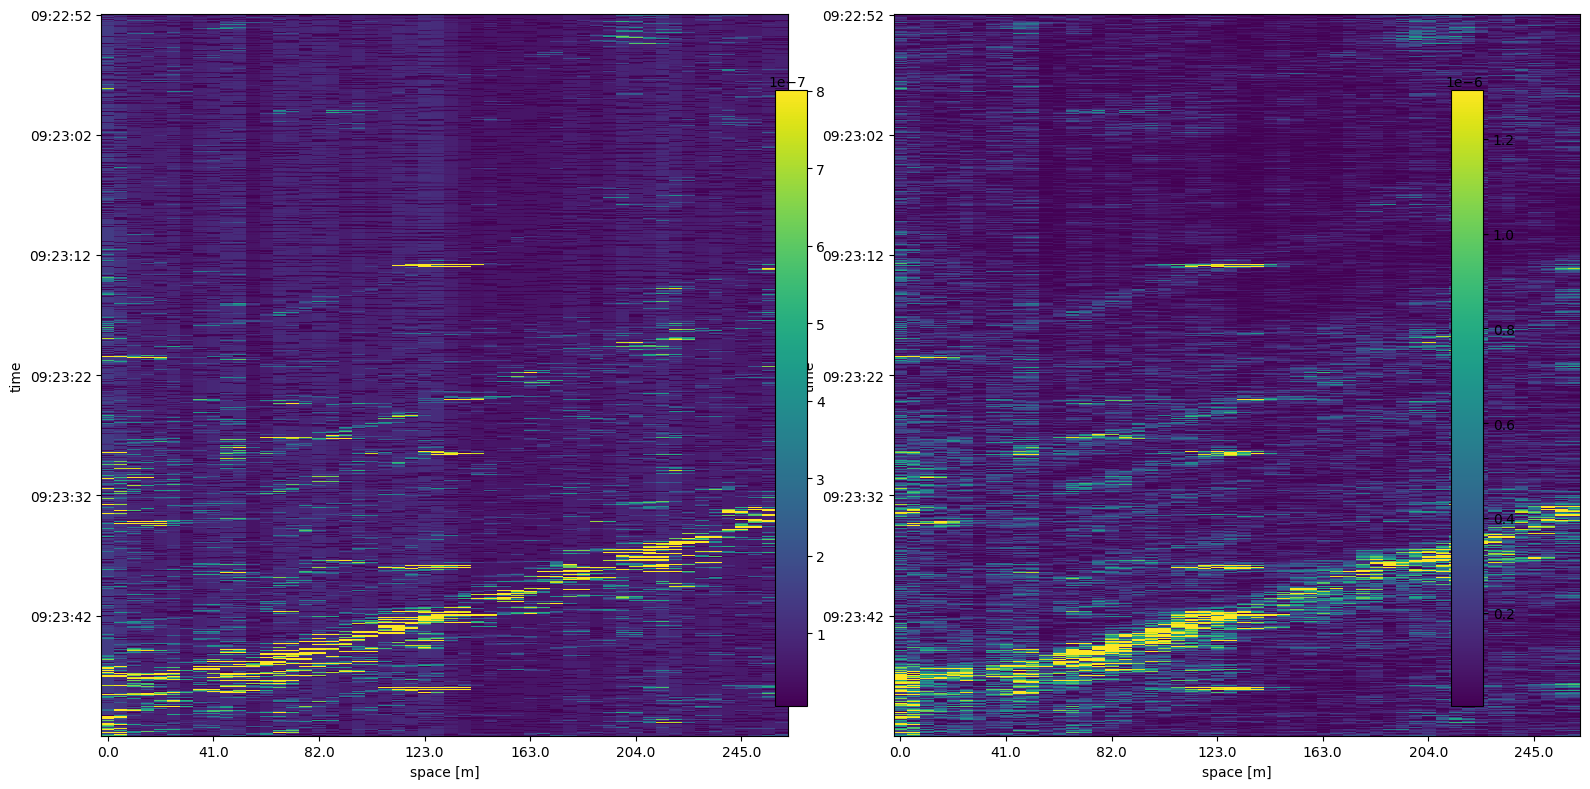

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


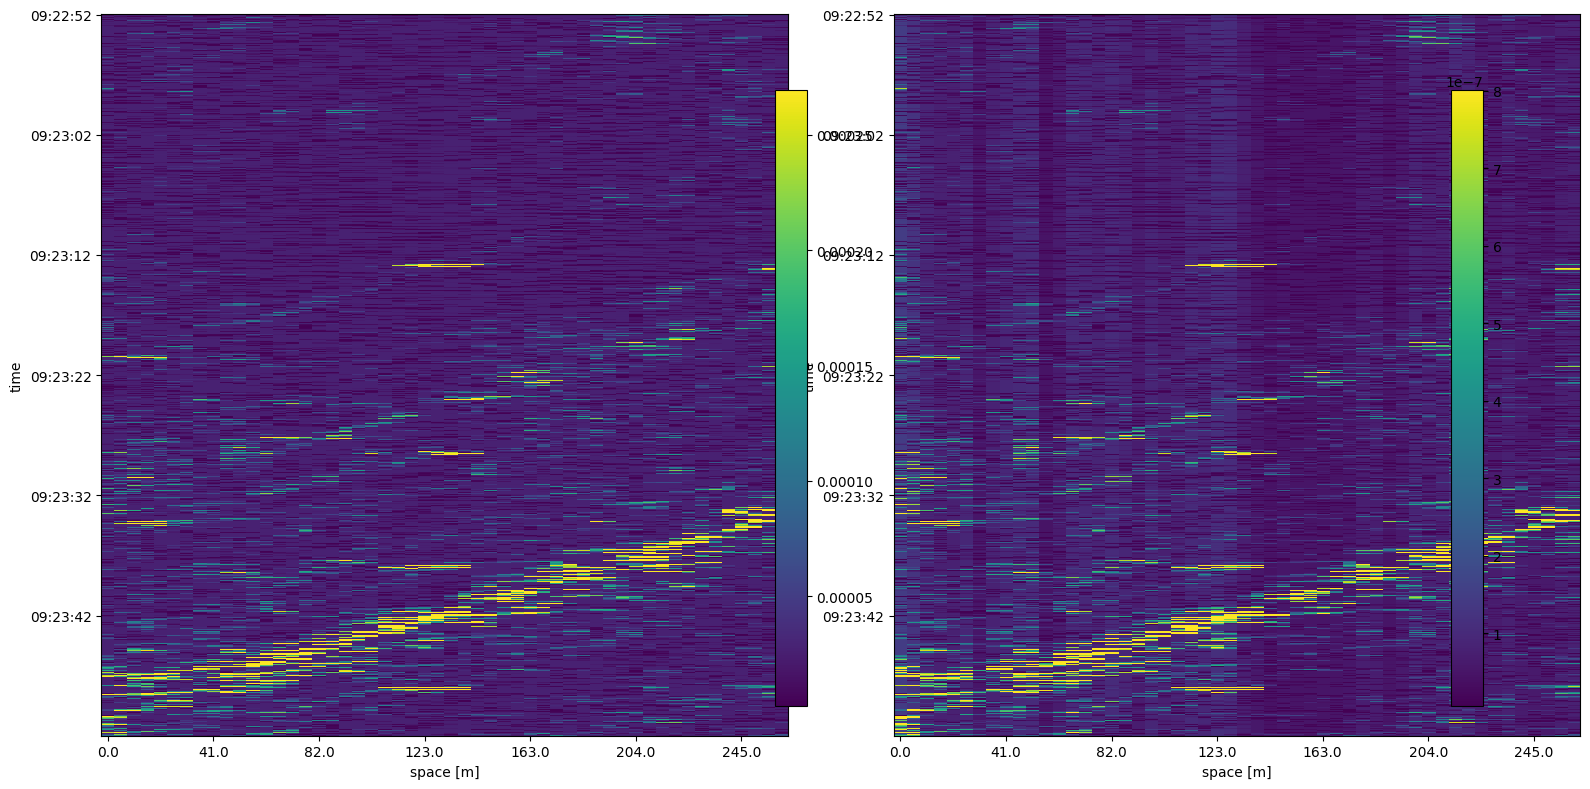

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


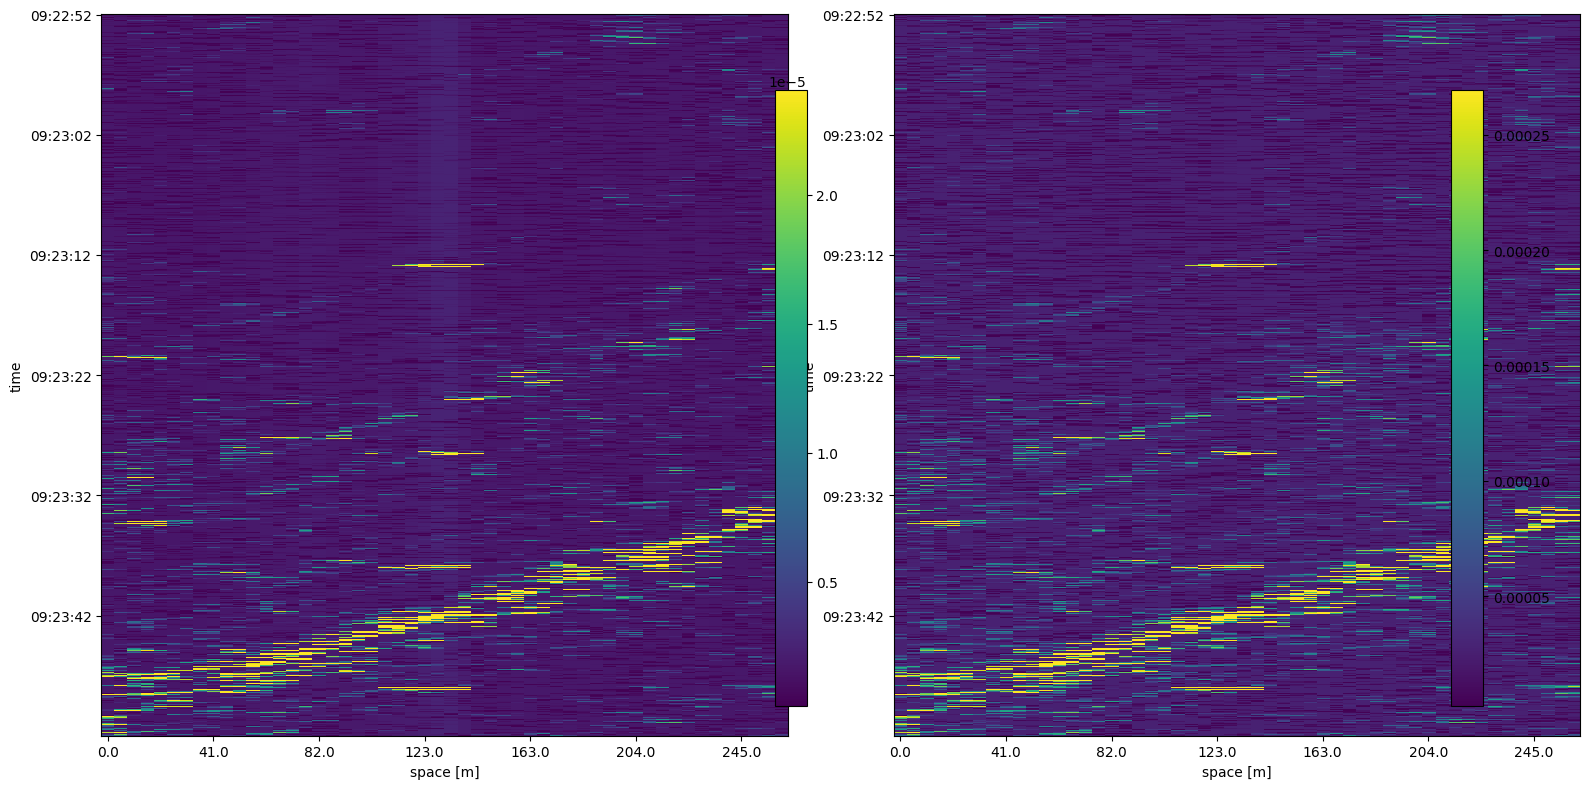

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


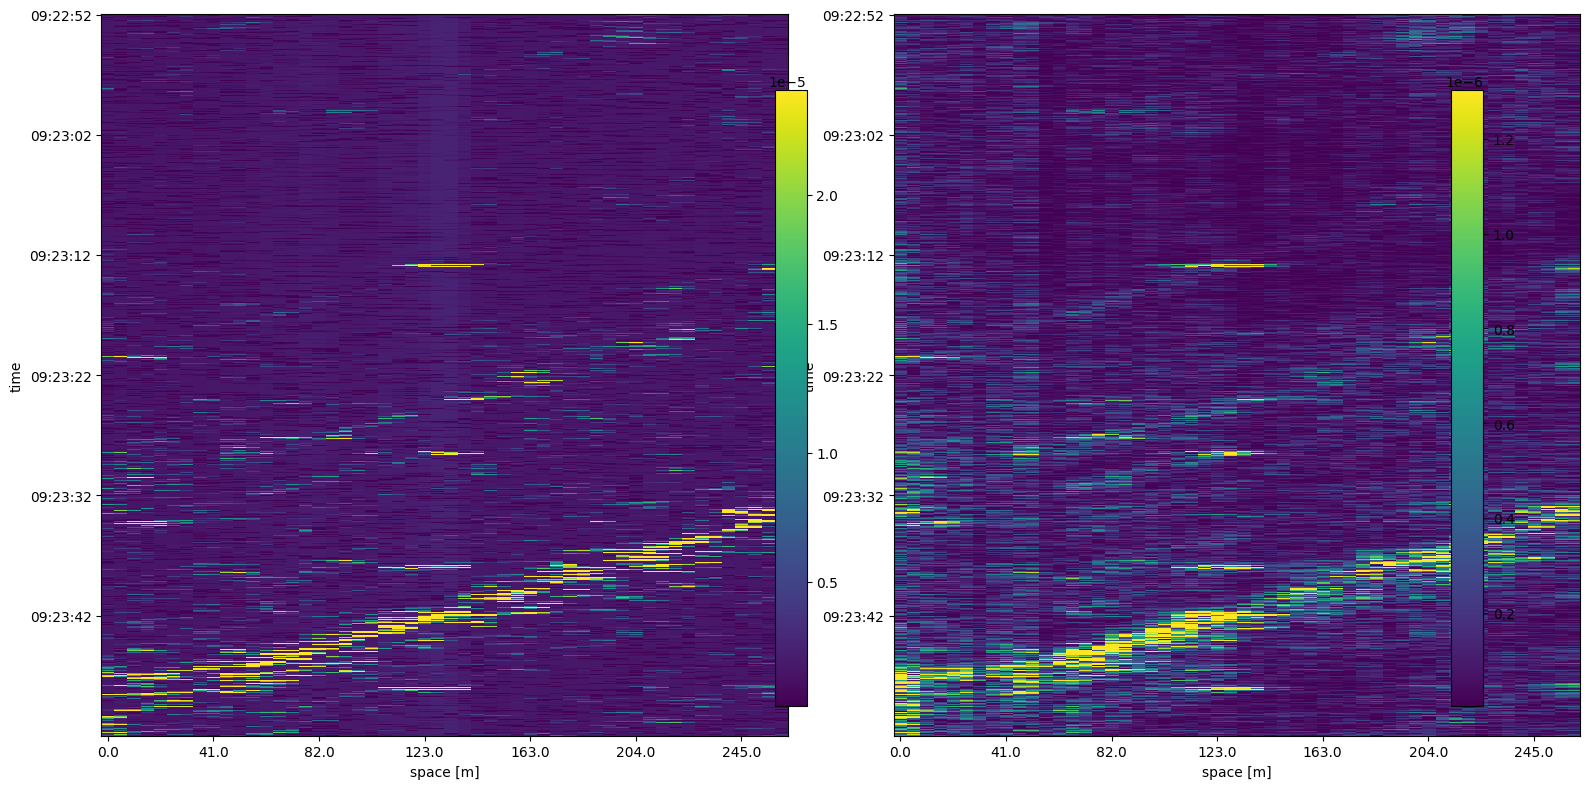

In [186]:
#plotting_function(df_3,True)
path_out = 'mateusz\\'

dfs = read_and_concatenate_files(path_out)

path_out_2 = 'noise\\'

dfs = dfs + read_and_concatenate_files(path_out_2)



data_mean_denoised = mean_denoising(dfs[2],dfs[0],3,True)
#display_two_plots(first,second)
plotting_function([data_mean_denoised,dfs[0]],True)

# data_column_denoised =column_denoising(data_3,df_1,3,True)
# plotting_function([data_column_denoised,df_1],True)
# display_multiple_plots([first,third])

# print("data mean denoised = data_column denoised")
# print(np.all(data_mean_denoised==data_column_denoised))

# noise_subtracted = subtract_noise(data_3,df_2,True)
# plotting_function([noise_subtracted,df_2],True)

mean_normalized = normalizing_columns(data_mean_denoised,1,True)
plotting_function([mean_normalized,data_mean_denoised],True)

mean_normalized_corrected = gamma_correction(mean_normalized,1.3)
plotting_function([mean_normalized_corrected,mean_normalized],True)


plotting_function([mean_normalized_corrected,dfs[0]],True)
# columns_mean_normalized = normalizing_columns(data_column_denoised,1,True)
# plotting_function([columns_mean_normalized,data_column_denoised],True)




# data_2_denoised = mean_denoising(data_3,columns_normalized,3,True)
# plotting_function([data_2_denoised,columns_normalized])

### time downsampling

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


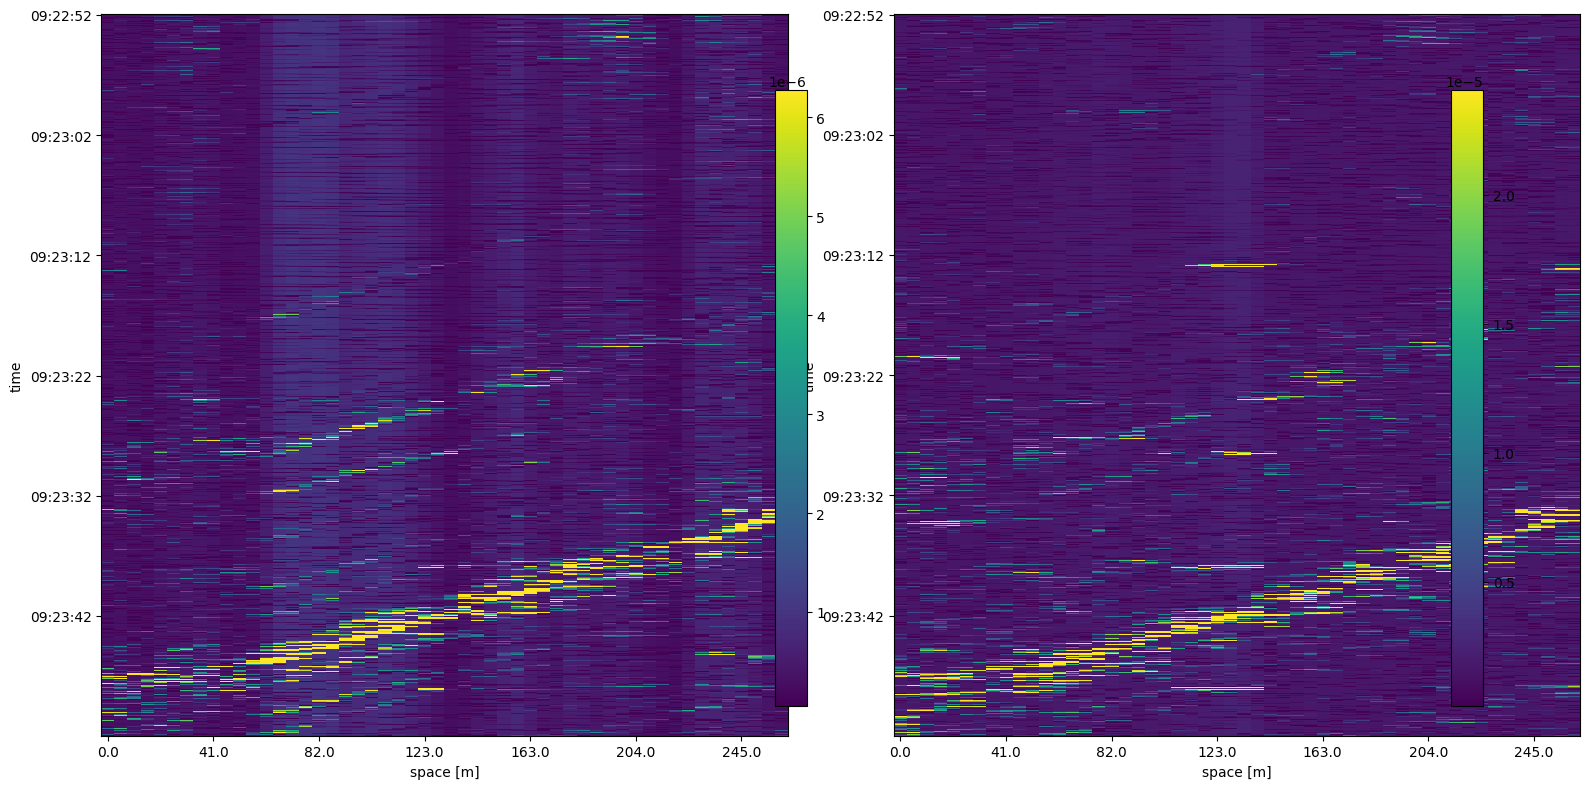

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


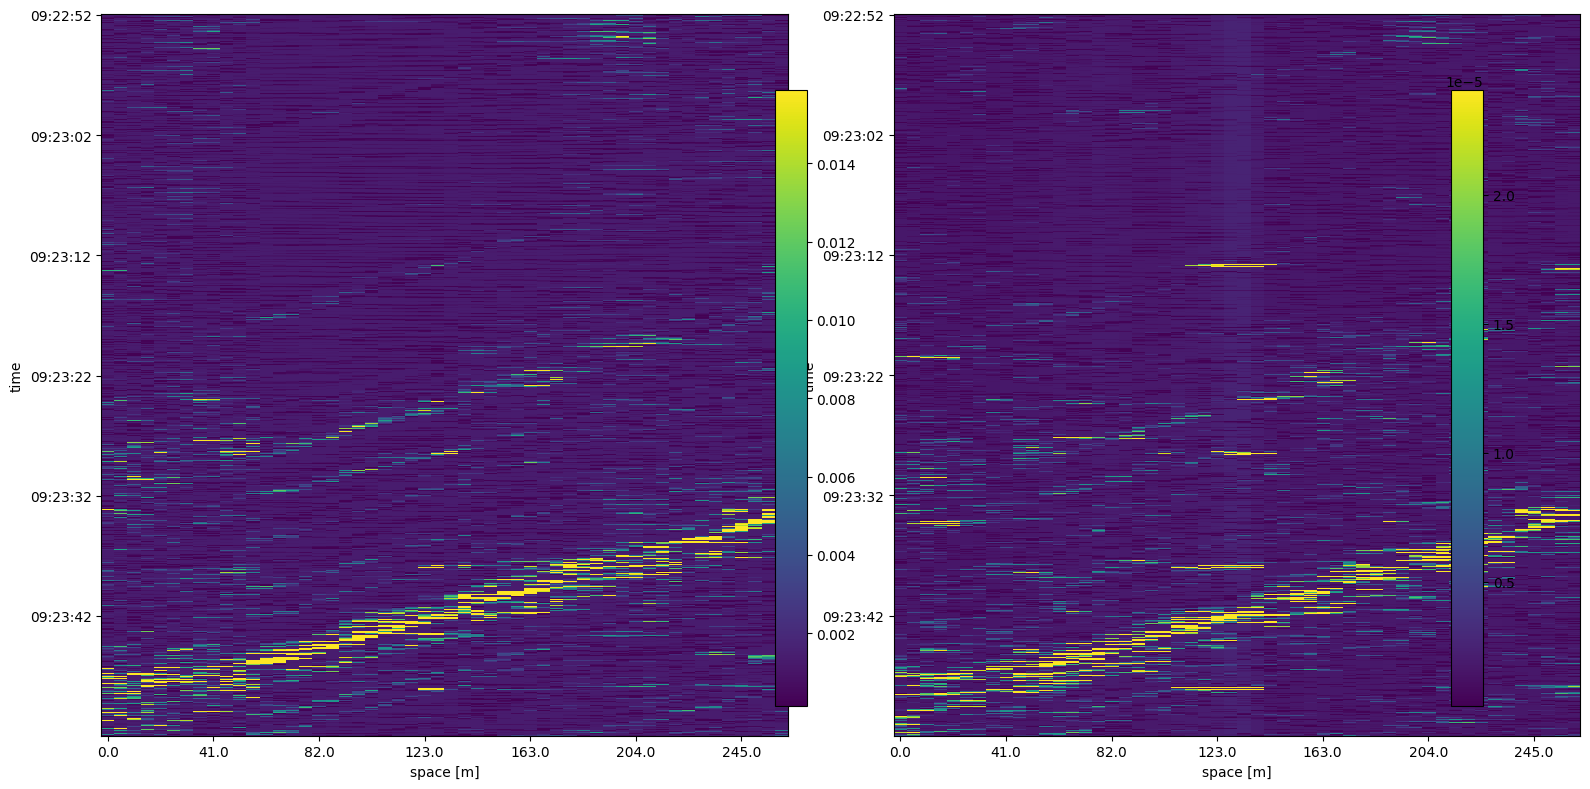

In [187]:
downsampled_median = downsampling_time_median(mean_normalized_corrected,50,True)
plotting_function([downsampled_median,mean_normalized_corrected],True)
downsampled_median_normalized = normalizing_columns(downsampled_median,1,True)
plotting_function([downsampled_median_normalized,mean_normalized_corrected],True)





### again denosing and also thresholding

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


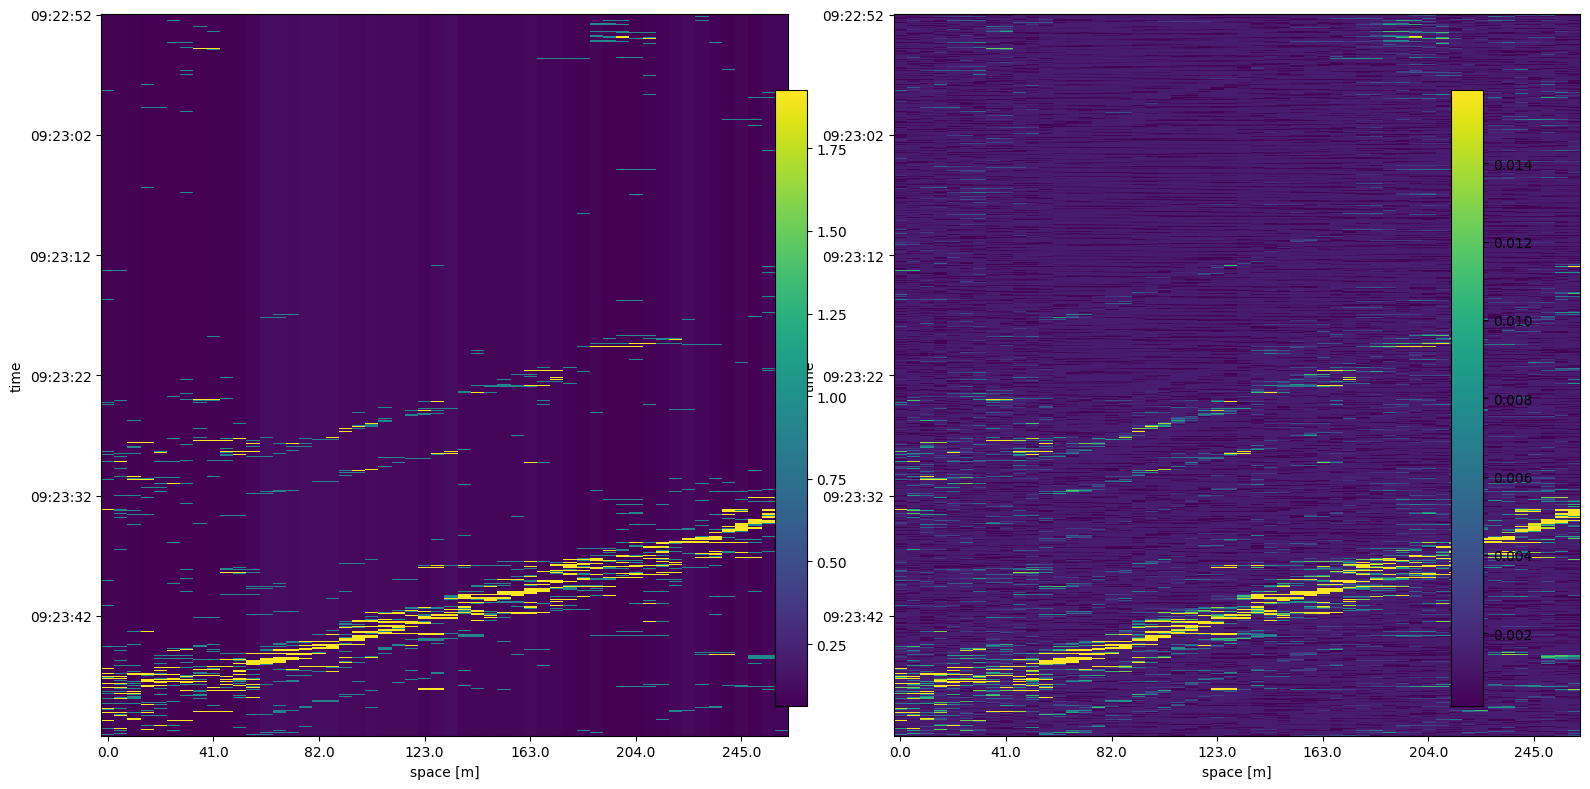

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


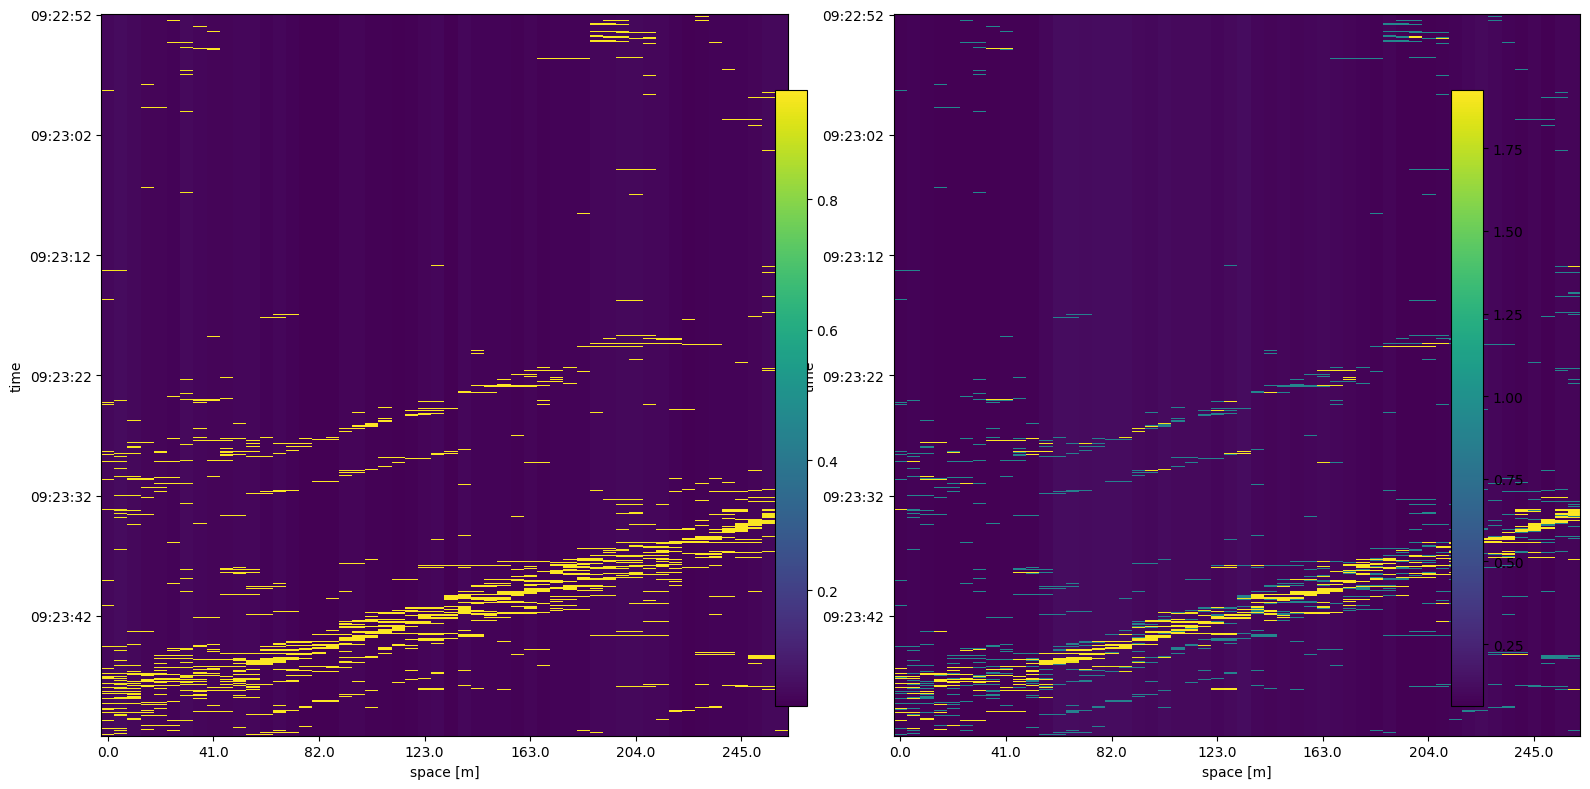

C:\Users\zenek\AppData\Local\Temp\ipykernel_36156\3428828863.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


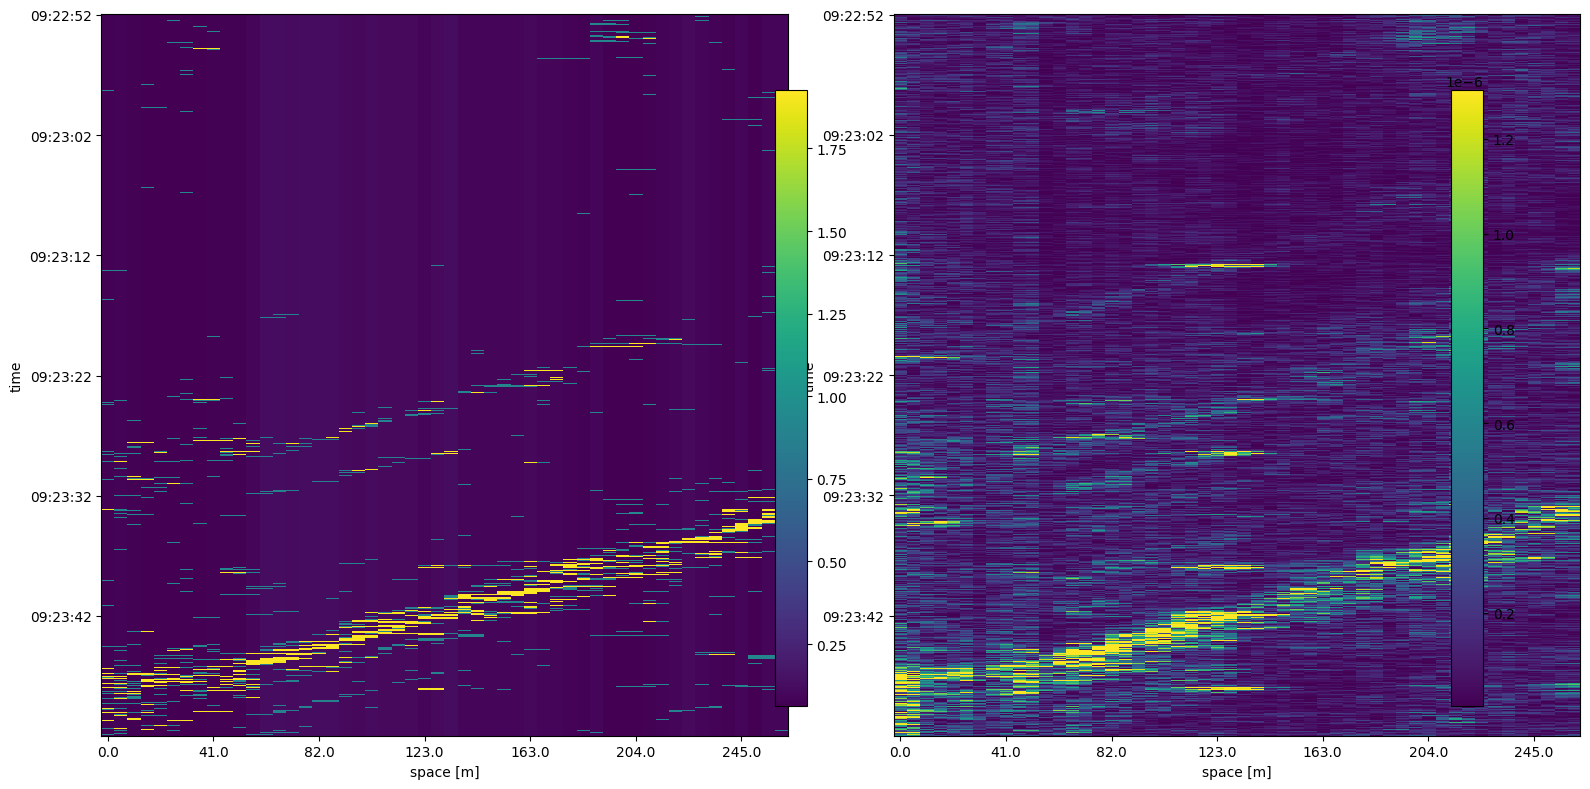

In [188]:
#would be probably desired to do some working kind of dilation beforhand
binarized = rescale_data(downsampled_median_normalized,scaling_parameter=150)
plotting_function([binarized,downsampled_median_normalized],True)


gamma_corrected = gamma_correction(binarized,1.2,True)


plotting_function([gamma_corrected,binarized],True)


plotting_function([binarized,dfs[0]],True)